# Time series analysis - Example code 17: Multivariate identification

**Lund University, Lund, Sweden**

See also example 7.10 in the textbook.

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')

from tsa_lth.multivariate import corrM, pacfM, lsVAR, lbp_test_multivariate
from tsa_lth.tools.mjbtest import mjbtest

## Simulate a VAR(2) process

In [2]:
np.random.seed(1)                                # Set the seed (just done for the lecture!)
N = 1000                                        # Try using a shorter realization.
m = 2                                           # Dimension of the VAR-process.
noLags = 10

# Simulate a VAR(2) process.
A1 = np.array([[.5, .4], [.1, .8]])            # Try changing the AR-polynomials (remember to check for stability!)
A2 = np.array([[-.2, -.1], [.3, .6]])
e = np.random.randn(m, N)
Y = np.zeros((m, N))

for k in range(2, N):
    Y[:, k] = -A1 @ Y[:, k-1] - A2 @ Y[:, k-2] + e[:, k]

## Plot the resulting processes

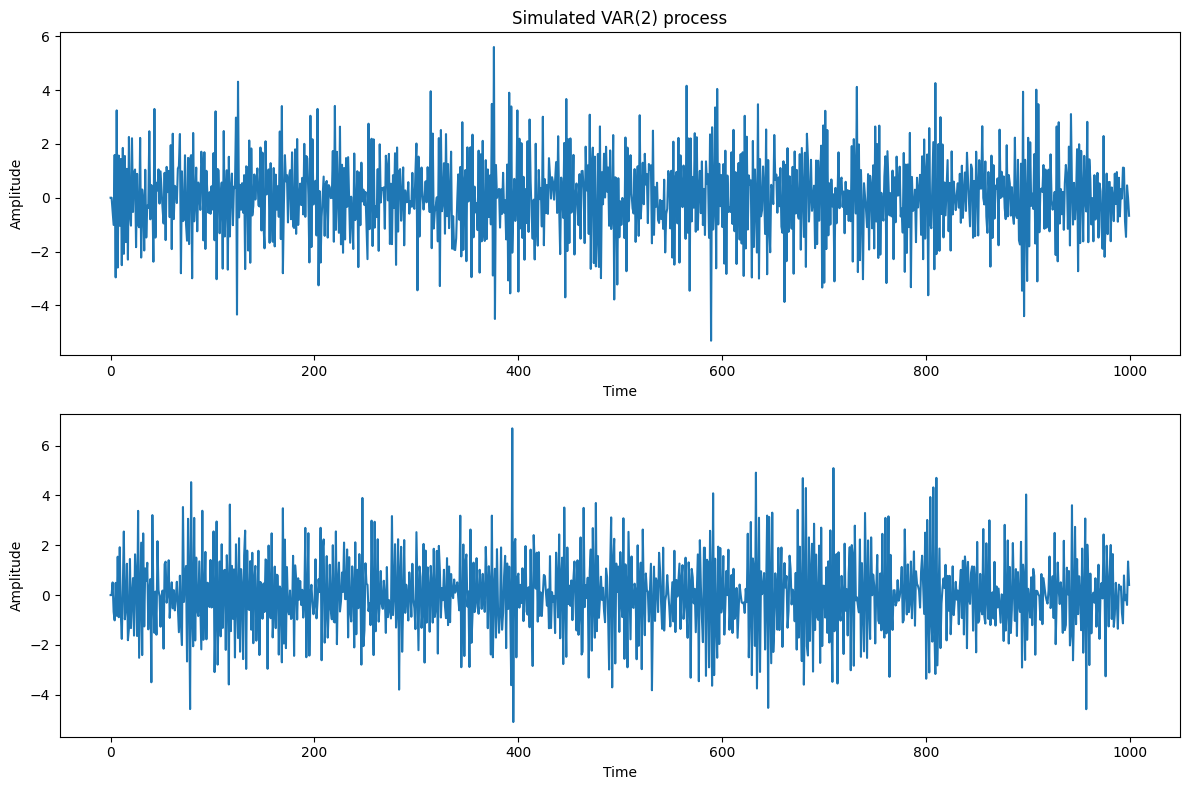

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(Y[0, :])
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.set_title('Simulated VAR(2) process')

ax2.plot(Y[1, :])
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Estimate the ACF and PACF

In [4]:
Ry, rhoY = corrM(Y, noLags)
S, _ = pacfM(Y, noLags)

print('The estimated covariance sequence is:')
Rya = np.hstack([Ry[0], Ry[1], Ry[2], Ry[3], Ry[4]])
print('Rya =')
print(Rya)

# Note: This is rho(0), rho(1), ...
print('\nThe estimated ACF is:')
Ra = np.hstack([rhoY[0], rhoY[1], rhoY[2], rhoY[3], rhoY[4]])
print('Ra =')
print(Ra)

# Note: This is theta(1), theta(2), ... (S[0] corresponds to lag 1 in Python, S{1} in MATLAB)
print('\nThe estimated PACF is:')
Sa = np.hstack([S[0], S[1], S[2], S[3], S[4]])
print('Sa =')
print(Sa)

signBound = 2 / np.sqrt(N)
print(f'\nThe (upper) confidence interval is {signBound:.4f}.')

The estimated covariance sequence is:
Rya =
[[ 2.4801037  -0.19875294 -1.65468435 -0.85999012  0.98812121  1.26690279
  -0.27055278 -0.91688326 -0.10137058  0.17064821]
 [-0.19875294  2.66854896  0.94986351 -1.50444822 -1.26627629 -0.21504276
   0.87602366  1.18356561 -0.2782322  -1.11703099]]

The estimated ACF is:
Ra =
[[ 1.         -0.07725757 -0.66718353 -0.33428813  0.39841931  0.4924598
  -0.1090893  -0.35640315 -0.04087353  0.06633294]
 [-0.07725757  1.          0.36922296 -0.56377014 -0.49221627 -0.08058415
   0.34052055  0.44352404 -0.10815208 -0.41859116]]

The estimated PACF is:
Sa =
[[-0.66718353  0.36922296  0.17872601  0.08687235  0.00291695  0.00882508
   0.02433878 -0.09200558 -0.01665705  0.0245654 ]
 [-0.33428813 -0.56377014 -0.14648622 -0.49332117 -0.00409875 -0.00557874
  -0.02940974 -0.00223708 -0.00388285  0.0076698 ]]

The (upper) confidence interval is 0.0632.


## Test if the ACF and PACF are normally distributed

In [5]:
# Test if the ACF and PACF are normally distributed.
if mjbtest(np.hstack([rhoY[1], rhoY[2], rhoY[3], rhoY[4], rhoY[5]]))[0]:
    print('The ACF is deemed NORMAL distributed.')
else:
    print('The ACF is NOT deemed normal distributed.')

if mjbtest(np.hstack([S[1], S[2], S[3], S[4], S[5]]))[0]:
    print('The PACF is deemed NORMAL distributed.')
else:
    print('The PACF is NOT deemed normal distributed.')

The ACF is deemed NORMAL distributed.
The PACF is deemed NORMAL distributed.


## Which values are outside the confidence interval?

In [6]:
print('The ACF values outside the confidence interval are:')
print(np.abs(Ra) > signBound)

print('The PACF values outside the confidence interval are:')
print(np.abs(Sa) > signBound)

The ACF values outside the confidence interval are:
[[ True  True  True  True  True  True  True  True False  True]
 [ True  True  True  True  True  True  True  True  True  True]]
The PACF values outside the confidence interval are:
[[ True  True  True  True False False False  True False False]
 [ True  True  True  True False False False False False False]]


## Estimate the AR polynomials for varying orders

In [7]:
# To deal with that Python uses 0-based indexing, store the
# vectors shifted one step (like MATLAB).
signLvl = 0.05
thEst = []
sigEst = []
resEst = []

for k in range(1, 7):
    th, sig, res = lsVAR(Y, k-1)
    thEst.append(th)
    sigEst.append(sig)
    resEst.append(res)

## Likelihood ratio test

In [8]:
M = np.zeros(5)
for p in range(2, 7):
    M[p-2] = -(N - p - p*m - 0.5) * np.log(np.linalg.det(sigEst[p-1]) / np.linalg.det(sigEst[p-2]))

chiV = chi2.ppf(1 - signLvl, m**2)
print(f'The threshold for the likelihood ratio test is {chiV:.4f}.')
print('The likelihood ratio test, for k=1, 2, ... (the model order estimate is the last non-zero ratio).')
print()
print(M)
print(M > chiV)

The threshold for the likelihood ratio test is 9.4877.
The likelihood ratio test, for k=1, 2, ... (the model order estimate is the last non-zero ratio).

[ 1.44495075e+03  4.15636953e+02 -1.20022317e+00  8.57335877e+00
  1.75242356e+00]
[ True  True False False False]


## Estimate the AIC, BIC, and FPE

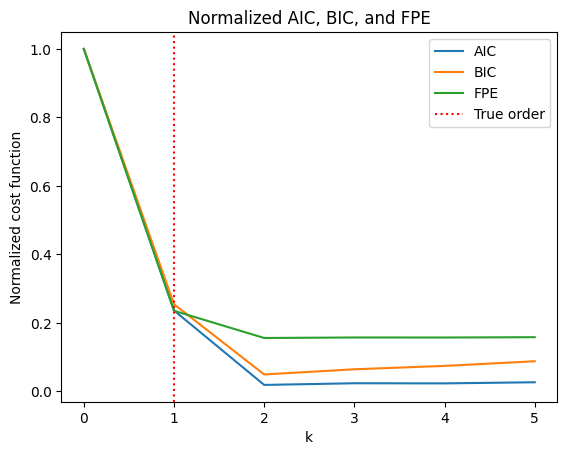

In [9]:
AIC = np.zeros(6)
BIC = np.zeros(6)
FPE = np.zeros(6)

for k in range(1, 7):
    AIC[k-1] = N * np.log(np.linalg.det(sigEst[k-1])) + 2*k*m**2
    BIC[k-1] = N * np.log(np.linalg.det(sigEst[k-1])) + k*m**2 * np.log(N)
    FPE[k-1] = ((N + m*k + 1) / (N - m*k - 1))**m * np.linalg.det(sigEst[k-1])

plt.figure()
plt.plot(np.column_stack([AIC / np.max(AIC), BIC / np.max(BIC), FPE / np.max(FPE)]))
plt.axvline(x=1, color='red', linestyle=':')
plt.title('Normalized AIC, BIC, and FPE')
plt.legend(['AIC', 'BIC', 'FPE', 'True order'])
plt.xlabel('k')
plt.ylabel('Normalized cost function')
plt.show()

## Form the LBP test for the different residuals

The threshold for the LBP test is 101.8795.


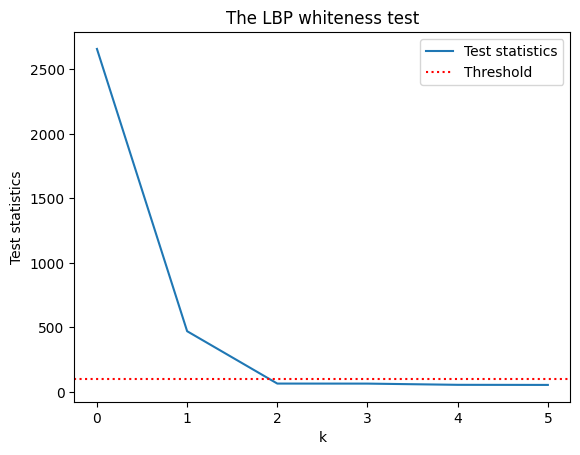

[False False  True  True  True  True]


In [10]:
deemedWhite = np.zeros(6, dtype=bool)
Q = np.zeros(6)

for k in range(1, 7):
    deemedWhite[k-1], Q[k-1], chiV = lbp_test_multivariate(resEst[k-1])

print(f'The threshold for the LBP test is {chiV:.4f}.')

plt.figure()
plt.plot(Q)
plt.axhline(y=chiV, color='red', linestyle=':')
plt.legend(['Test statistics', 'Threshold'])
plt.title('The LBP whiteness test')
plt.xlabel('k')
plt.ylabel('Test statistics')
plt.show()

print(deemedWhite)